In [ ]:
!pip3 install imblearn

In [ ]:
!pip3 install opencv-contrib-python

In [ ]:
import os
import cv2
import numpy as np
from skimage.morphology import skeletonize
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier


# Function to extract only handcrafted features
def extract_features(image):
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Binarize the image
    _, binary = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY_INV)

    # Skeletonization using skimage
    skeleton = skeletonize(binary > 0)

    # Handcrafted Features
    h, w = binary.shape
    aspect_ratio = h / w
    ink_density = np.sum(binary > 0) / (h * w)
    stroke_width = np.std(skeleton)

    return [aspect_ratio, ink_density, stroke_width]

# Function to load dataset
def load_dataset(genuine_path, forged_path):
    X, y = [], []

    # Load Genuine Signatures
    for filename in os.listdir(genuine_path):
        img_path = os.path.join(genuine_path, filename)
        img = cv2.imread(img_path)
        if img is None:
            continue
        features = extract_features(img)
        X.append(features)
        y.append(1)

    # Load Forged Signatures
    for filename in os.listdir(forged_path):
        img_path = os.path.join(forged_path, filename)
        img = cv2.imread(img_path)
        if img is None:
            continue
        features = extract_features(img)
        X.append(features)
        y.append(0)

    return np.array(X), np.array(y)


In [ ]:
import zipfile
with zipfile.ZipFile("/content/new.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/signature/")

In [ ]:
import time

# Paths to dataset
genuine_path = "/content/signature/Genuine/"
forged_path = "/content/signature/Forged/"

# Load Data
X, y = load_dataset(genuine_path, forged_path)

# Normalize Features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Hyperparameter tuning for SVM (not directly used here but still timed)
param_dist = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf']
}

print("Starting SVM hyperparameter tuning...")
start_time = time.time()
random_search = RandomizedSearchCV(SVC(kernel='rbf'), param_dist, n_iter=10, cv=3, verbose=2, n_jobs=-1)
random_search.fit(X_train, y_train)
svm_time = time.time() - start_time
print(f"SVM hyperparameter tuning took {svm_time:.2f} seconds.")

# Random Forest Classifier
print("Training Random Forest model...")
start_time = time.time()
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_time = time.time() - start_time
print(f"Random Forest training took {rf_time:.2f} seconds.")

# Predictions
y_pred_rf = rf_model.predict(X_test)

# Accuracy and Confusion Matrix
accuracy_rf = accuracy_score(y_test, y_pred_rf)
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
tn_rf, fp_rf, fn_rf, tp_rf = conf_matrix_rf.ravel()
far_rf = fp_rf / (fp_rf + tn_rf)
frr_rf = fn_rf / (fn_rf + tp_rf)

# Results
print("\n--- Random Forest ---")
print(f"Accuracy: {accuracy_rf * 100:.2f}%")
print("Confusion Matrix:\n", conf_matrix_rf)
print(f"False Acceptance Rate (FAR): {far_rf:.2f}")
print(f"False Rejection Rate (FRR): {frr_rf:.2f}")


Starting SVM hyperparameter tuning...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
SVM hyperparameter tuning took 4.06 seconds.
Training Random Forest model...
Random Forest training took 0.44 seconds.

--- Random Forest ---
Accuracy: 92.00%
Confusion Matrix:
 [[188   8]
 [ 16  88]]
False Acceptance Rate (FAR): 0.04
False Rejection Rate (FRR): 0.15


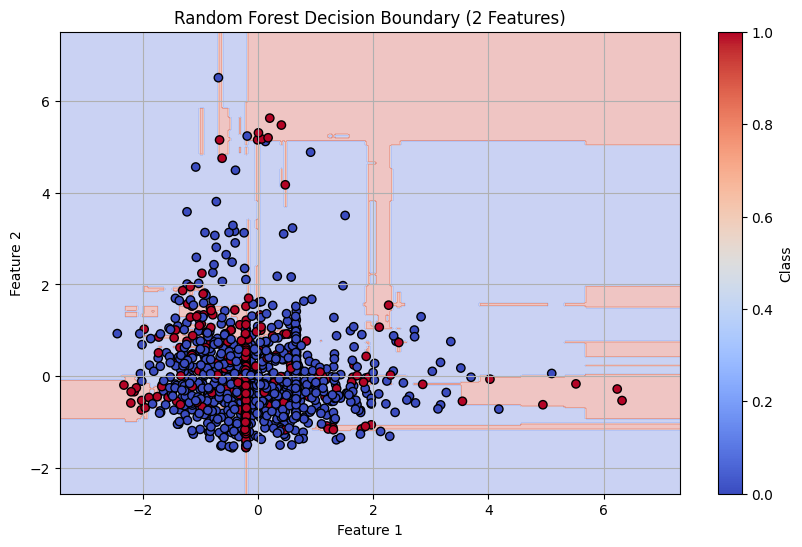

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                     np.linspace(y_min, y_max, 300))

# Retrain the RF model using only the two features (just for visualization)
rf_model_2d = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_2d.fit(X_train[:, :2], y_train)

# Predict on grid
Z = rf_model_2d.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot
plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.coolwarm, edgecolors='k')
plt.title("Random Forest Decision Boundary (2 Features)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.colorbar(label='Class')
plt.grid(True)
plt.show()


In [ ]:
import joblib

joblib.dump(rf_model, "./signature/random_forest_92.pkl")

In [ ]:
import joblib

rf = joblib.load("./signature/random_forest_92.pkl")

In [ ]:
# Paths to dataset
genuine_path = "./signature/new/Genuine/"
forged_path = "./signature/new/Forged/"

# Load Data
X, y = load_dataset(genuine_path, forged_path)

# Normalize Features
scaler = joblib.load("./signature/scaler_rf_knn.pkl")
X = scaler.fit_transform(X)

# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Predictions
y_pred = rf.predict(X_test)

# Accuracy and Confusion Matrix
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Calculate False Acceptance Rate (FAR) and False Rejection Rate (FRR)
tn, fp, fn, tp = conf_matrix.ravel()
far = fp / (fp + tn)
frr = fn / (fn + tp)

# Results
print(f"Accuracy: {accuracy * 100:.2f}%")
print("Confusion Matrix:\n", conf_matrix)
print(f"False Acceptance Rate (FAR): {far:.2f}")
print(f"False Rejection Rate (FRR): {frr:.2f}")

Accuracy: 92.67%
Confusion Matrix:
 [[190   6]
 [ 16  88]]
False Acceptance Rate (FAR): 0.03
False Rejection Rate (FRR): 0.15


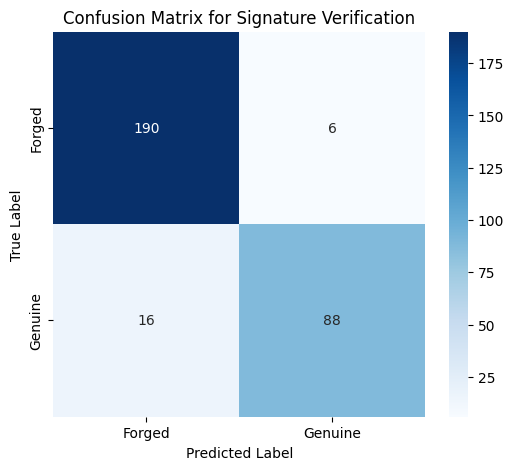

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Forged', 'Genuine'], yticklabels=['Forged', 'Genuine'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Signature Verification')
plt.show()


In [ ]:
import joblib

# Load the trained model and scaler
svm_model = joblib.load("./signature/knn_86.pkl")
scaler = joblib.load("./signature/scaler.pkl")

# new_image = cv2.imread("./signature/Forged/Forged with labels/Abel_Forged5.jpg")
# new_image = cv2.imread("./signature/Genuine/Genuine w- labels/Abel_Genuine3.jpeg")

new_image = cv2.imread("./preprocessed_images/Forged/Cosio_Forged8_1_grayscale.png")


features = extract_features(new_image)
features = scaler.transform([features])

prediction = svm_model.predict(features)
if prediction[0] == 1:
    print("The signature is Genuine ✅")
else:
    print("The signature is Forged ❌")


In [ ]:
import os
import cv2
import numpy as np
from skimage.morphology import skeletonize

def save_extracted_images(image, filename, save_path):
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    # Check if the image is already in grayscale
    if len(image.shape) == 3:
        grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        grayscale = image.copy()

    # Save the grayscaled image
    cv2.imwrite(os.path.join(save_path, f"{filename}_1_grayscale.png"), grayscale)

    # Binarization
    _, binary = cv2.threshold(grayscale, 128, 255, cv2.THRESH_BINARY_INV)

    # Save the grayscale and binarized image
    cv2.imwrite(os.path.join(save_path, f"{filename}_1_grayscale_binarized.png"), grayscale)

    skeleton = skeletonize(binary > 0).astype(np.uint8)*255

    # Save the grayscale, binarized and skeletonized image
    cv2.imwrite(os.path.join(save_path, f"{filename}_1_grayscale_binarized_skeletonized.png"), grayscale)

In [ ]:
# Saving usage

def process_images_from_folder(folder_path, save_folder):
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)

        img = cv2.imread(img_path)

        if img is None:
            print(f"Skipping {filename}, invalid image file")
            continue

        save_extracted_images(img, filename.split('.')[0], save_folder)


genuine_path = "./signature/Genuine/Genuine w- labels"
forged_path = "./signature/Forged/Forged with labels"

process_images_from_folder(genuine_path, "./preprocessed_images/Genuine")
process_images_from_folder(forged_path, "./preprocessed_images/Forged")

print("Preprocessing completed. Check the preprocessed folder")

In [ ]:
!ls "./preprocessed_images/Forged"

In [ ]:
import os
import cv2
import numpy as np
from skimage.morphology import skeletonize
from skimage.util import img_as_ubyte

# Input folders
genuine_path = "./signature/new/Genuine/"
forged_path = "./signature/new/Forged/"

# Output base folders
output_base = "./output_steps"
stages = ["GRAYSCALE", "GRAYSCALE_BINARIZATION", "GRAYSCALE_BINARIZATION_SKELETONIZE"]
types = ["genuine", "forged"]

# Create directory structure
for stage in stages:
    for sig_type in types:
        os.makedirs(os.path.join(output_base, stage, sig_type), exist_ok=True)

# Helper function to process and save images
def process_image(image_path, filename, label):
    image = cv2.imread(image_path)

    if image is None:
        print(f"Skipping: {filename} (invalid image)")
        return

    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray_path = os.path.join(output_base, "GRAYSCALE", label, filename)
    cv2.imwrite(gray_path, gray)

    # Binarization
    _, binary = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY_INV)
    binary_path = os.path.join(output_base, "GRAYSCALE_BINARIZATION", label, filename)
    cv2.imwrite(binary_path, binary)

    # Skeletonization
    skeleton = skeletonize(binary > 0)
    skeleton_uint8 = img_as_ubyte(skeleton)
    skeleton_path = os.path.join(output_base, "GRAYSCALE_BINARIZATION_SKELETONIZE", label, filename)
    cv2.imwrite(skeleton_path, skeleton_uint8)

    print(f"Processed: {label}/{filename}")

# Process genuine signatures
for filename in os.listdir(genuine_path):
    process_image(os.path.join(genuine_path, filename), filename, label="genuine")

# Process forged signatures
for filename in os.listdir(forged_path):
    process_image(os.path.join(forged_path, filename), filename, label="forged")


Processed: genuine/Caringal_Genuine2.jpg
Processed: genuine/Morales_Genuine7.jpg
Processed: genuine/Olivar-Genuine3.jpeg
Processed: genuine/Carandang_Genuine8.jpg
Processed: genuine/Villapando-Genuine10.jpg
Processed: genuine/Gahol-Genuine7.jpeg
Processed: genuine/Sangalang-Genuine2.jpeg
Processed: genuine/Lagman-Genuine9.jpeg
Processed: genuine/Sangalang-Genuine3.jpeg
Processed: genuine/Lagman-Genuine3.jpeg
Processed: genuine/Olivar-Genuine7.jpeg
Processed: genuine/Cay_Genuine4.jpg
Processed: genuine/Villapando-Genuine8.jpg
Processed: genuine/Cosio_Genuine1.jpeg
Processed: genuine/Lagman-Genuine7.jpeg
Processed: genuine/Carandang_Genuine2.jpg
Processed: genuine/Ronquillo-Genuine6.jpeg
Processed: genuine/Espiritu_Genuine1.jpeg
Processed: genuine/Ronquillo-Genuine10.jpeg
Processed: genuine/Olivar-Genuine8.jpeg
Processed: genuine/Nicanor-Genuine10.jpeg
Processed: genuine/Eleda_Genuine5.jpeg
Processed: genuine/Santos-Genuine7.jpeg
Processed: genuine/Santos-Genuine4.jpeg
Processed: genuine